In [1]:
"""
Minimal working example.
"""
import sys 
sys.path.append('../src/')
import detector as de
import extractor as ex
import accumulator as ac
import utils
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from collections import defaultdict
import networkx as nx
import seaborn as sns
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

# Read image

In [3]:
FILENAME = "../scripts/img01.png"

# Read the image and chenge encoding
img = cv2.imread(FILENAME, cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # TO PLOT WITH MATPLOTLIB

# A. Feature Localization and Extraction

- Localization strategy: Canny
- Descriptor: DAISY 

In [4]:
# Detects interesting points
kpdetector = de.KeypointsDetector()
keypoints = kpdetector.canny(img)

# Extracts the descriptors from previous detected points
extractor = ex.DescriptorExtractor()
descriptors = extractor.daisy(keypoints, img)

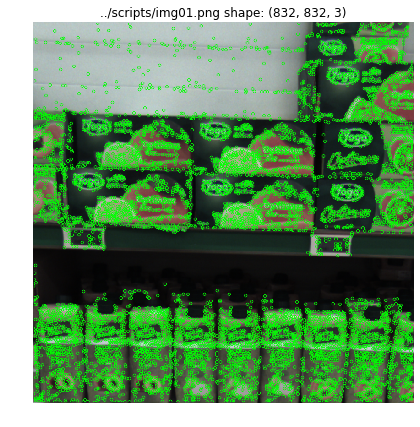

In [5]:
# Visualization
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax.imshow(img)
ax.axis('off')
ax.set_title(f"{FILENAME} shape: {img.shape}")
ax.imshow(cv2.drawKeypoints(img, keypoints, img.copy(),(0,255,0)))
plt.show()


# B. Semantical Hot Spots Detection

- For each src descriptor compute top `K` approximate dst neighbors
- Add splash ends in Accumulator 
    - Gaussian voting scheme ksize=11. Kernel sums to 1.
    - Exponential decreasing weight of the gaussian. `kernel * 1/rank`
    - Do NOT include splash ends within `RADIUS`
    


In [6]:
# Declaration of the Accumulator
accumulator = ac.Accumulator(img)

# PARAMETERS
K =  7
RADIUS = 100

# Implementation uses FLANN matcher instead of descriptor matrix
FLANN_INDEX_KDTREE = 0
flann = cv2.FlannBasedMatcher(dict(algorithm = FLANN_INDEX_KDTREE, trees = 5), dict(checks=50))
matches = flann.knnMatch(descriptors,descriptors,k=K)

for i, m_list in enumerate(matches):
    o = (int(keypoints[i].pt[1]), int(keypoints[i].pt[0]))
    points = []
    rank = 1
    for m in m_list:
        d = (int(keypoints[m.trainIdx].pt[1]), int(keypoints[m.trainIdx].pt[0]))
        # Removes the points near the source
        if utils.eu_dist(o, d) > RADIUS:
            points.append(d)
            accumulator.add_vote(o, d, rank**2, ksize=11)
            rank += 1
    accumulator.add_splash(o, points)


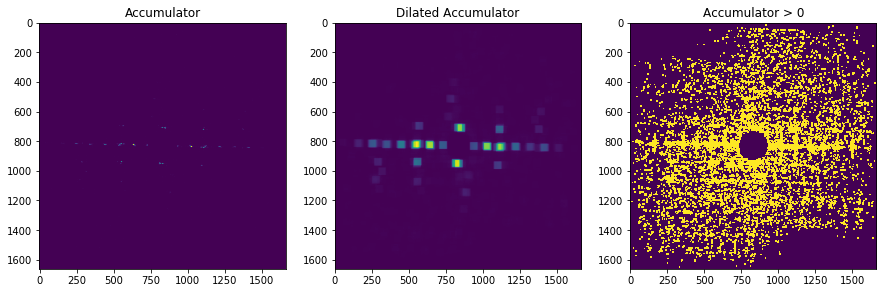

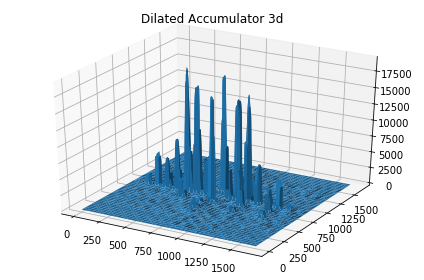

In [7]:
# Accumulator visualization
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

axs[0].set_title("Accumulator")
axs[0].imshow(accumulator.accumulator)

axs[1].set_title("Dilated Accumulator")
axs[1].imshow(cv2.filter2D(accumulator.accumulator,-1, np.ones((51,51),np.uint8)))

axs[2].set_title("Accumulator > 0")
axs[2].imshow(accumulator.accumulator>0)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
y = np.arange(0, accumulator.accumulator.shape[0])
x = np.arange(0, accumulator.accumulator.shape[1])
x, y = np.meshgrid(x, y)
ax.set_title("Dilated Accumulator 3d")
ax.plot_surface(x,y, cv2.filter2D(accumulator.accumulator,-1, np.ones((51,51),np.uint8)))
plt.tight_layout()
plt.show()

## Accumulator Space Thresholding 

Just threshold above 5% max or less.


In [8]:
THRESHOLD = 1.5
x, y = np.where(accumulator.accumulator > THRESHOLD)

# Vote list is V in the paper
vote_list = accumulator.votes.copy()
idx1 = np.nonzero(np.isin(vote_list[:,0], x))[0]
idx2 = np.nonzero(np.isin(vote_list[idx1,1], y))[0]
idx3 = idx1[idx2]
mask = np.zeros(vote_list.shape[0])

coords = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)

for coord in coords:
    idx4 = np.where(np.all(vote_list[idx3,0:2] == coord, axis=1))[0]
    mask[idx3[idx4]] = 1

vote_list = vote_list[np.nonzero(mask)[0]]

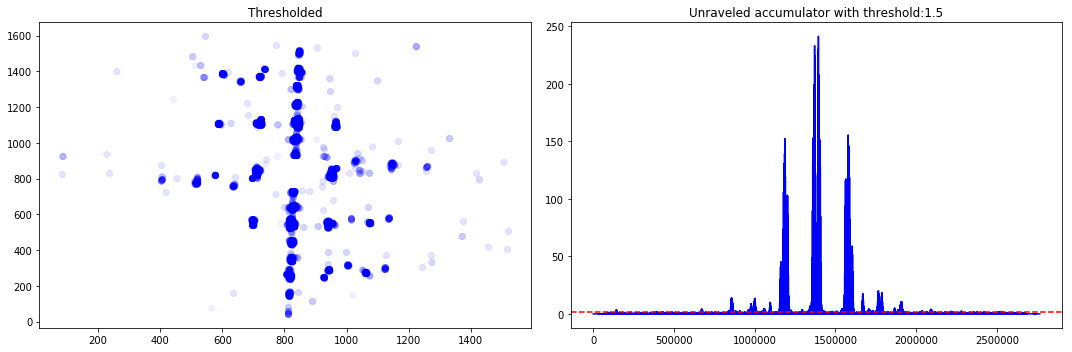

In [11]:
# Debug plot
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title(f"Thresholded")
plt.scatter(vote_list[:,0], vote_list[:,1], c='b', alpha=0.05)

plt.subplot(1,2,2)
plt.title(f"Unraveled accumulator with threshold:{THRESHOLD}")
plt.plot(accumulator.accumulator.flatten(), c='b')
plt.axhline(y=THRESHOLD, color='r', linestyle='dashed')
plt.tight_layout()

## Backprojection

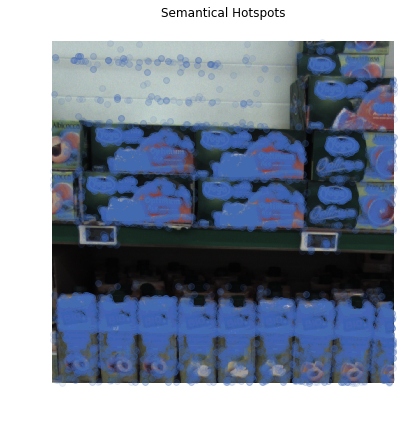

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
plt.axis('off')
ax.imshow(img)
ax.set_title("Semantical Hotspots")
ax.scatter(vote_list[:,3], vote_list[:,2], c='#426ab9ff', alpha=0.1)
plt.show()

# C. Semantical Categories Definition and Extraction


In [13]:
# Run from here with different N_SUPERPIXELS values to reach other semantical level
# N_SUPERPIXELS = 40 replicates the image in the paper
N_SUPERPIXELS = 300

segments = slic(img, n_segments = N_SUPERPIXELS, compactness=20,sigma = 3)

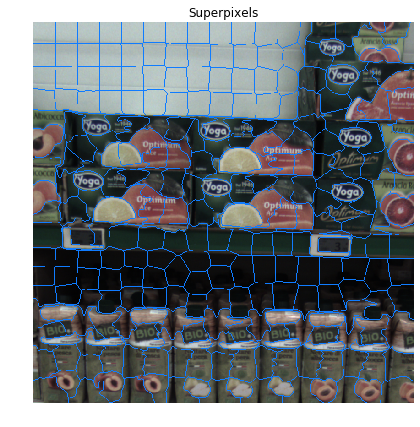

In [14]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax.imshow(mark_boundaries(img, segments,color=(16/255, 124/255, 255/255), mode="thick"))
ax.set_title("Superpixels")
ax.axis("off")
plt.show()

## Graph creation

- $G=(V,E)$ 
    - $|V|=$ number of clusters found
    - $E =$ Put 1 vote between $v_{1}$ and $v_{2}$ if there is an agreement between two superpixels


In [15]:
connections = []
for vote in vote_list:
    pi1 = vote[2:4]
    pi2 = vote[4:6]
    connections.append((segments[pi1[0],pi1[1]],segments[pi2[0],pi2[1]]))

In [16]:
n_clusters = segments.max()+1

In [17]:
adj_mat = np.zeros((n_clusters, n_clusters))
for c in connections:
    adj_mat[c[0], c[1]] += 1
    adj_mat[c[1], c[0]] += 1

np.fill_diagonal(adj_mat, 0)

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


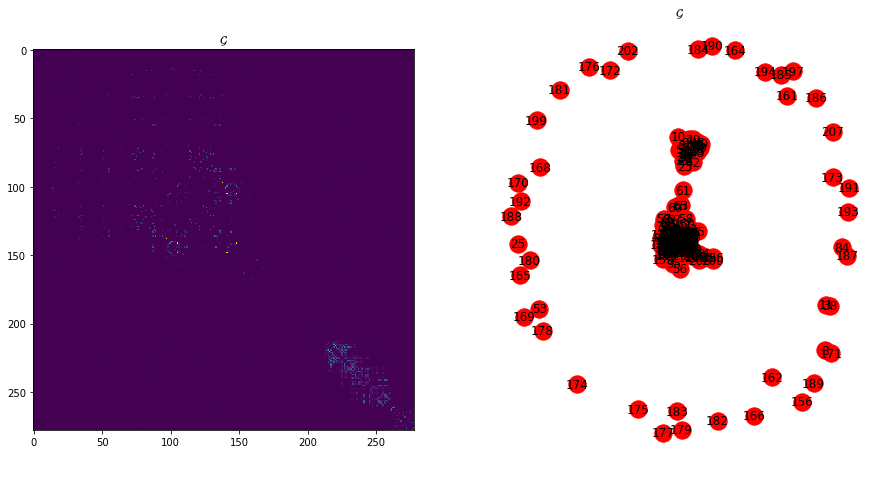

In [18]:
 # Visualization
fig = plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title("$\mathcal{G}$")
plt.imshow(adj_mat)


# Draw graph
G = nx.from_numpy_array(adj_mat)
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
weights = np.array(weights)
weights /= weights.max()
maxw = weights.max()
weights *= 10
plt.subplot(1,2,2)
plt.title("$\mathcal{G}$")
nx.draw(G, node_color='r', with_labels=True, edge_color=weights, width=weights, cmap=plt.cm.jet)#,  pos = pos)
plt.show()

## Discover Categories

- Find densely connected components by iterative process: graph corrosion
- At each iteration corrode the graph $G-min(E)$ and compute a score as follows:

$s(G, K)=\sum_{k \in K} \mu(k)-\alpha|K|$

Maximize the score to find optimum partition

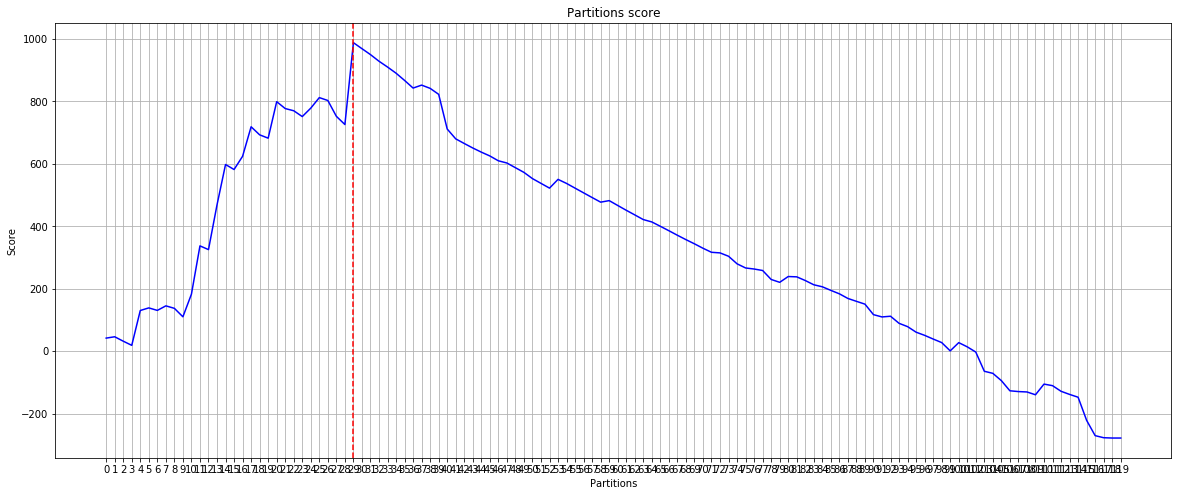

In [19]:
best_partition_nodes, best_partition = utils.findBestPartition_alt(adj_mat, alpha=1, viz=True)

## Plot of categories and subgraphs extracted

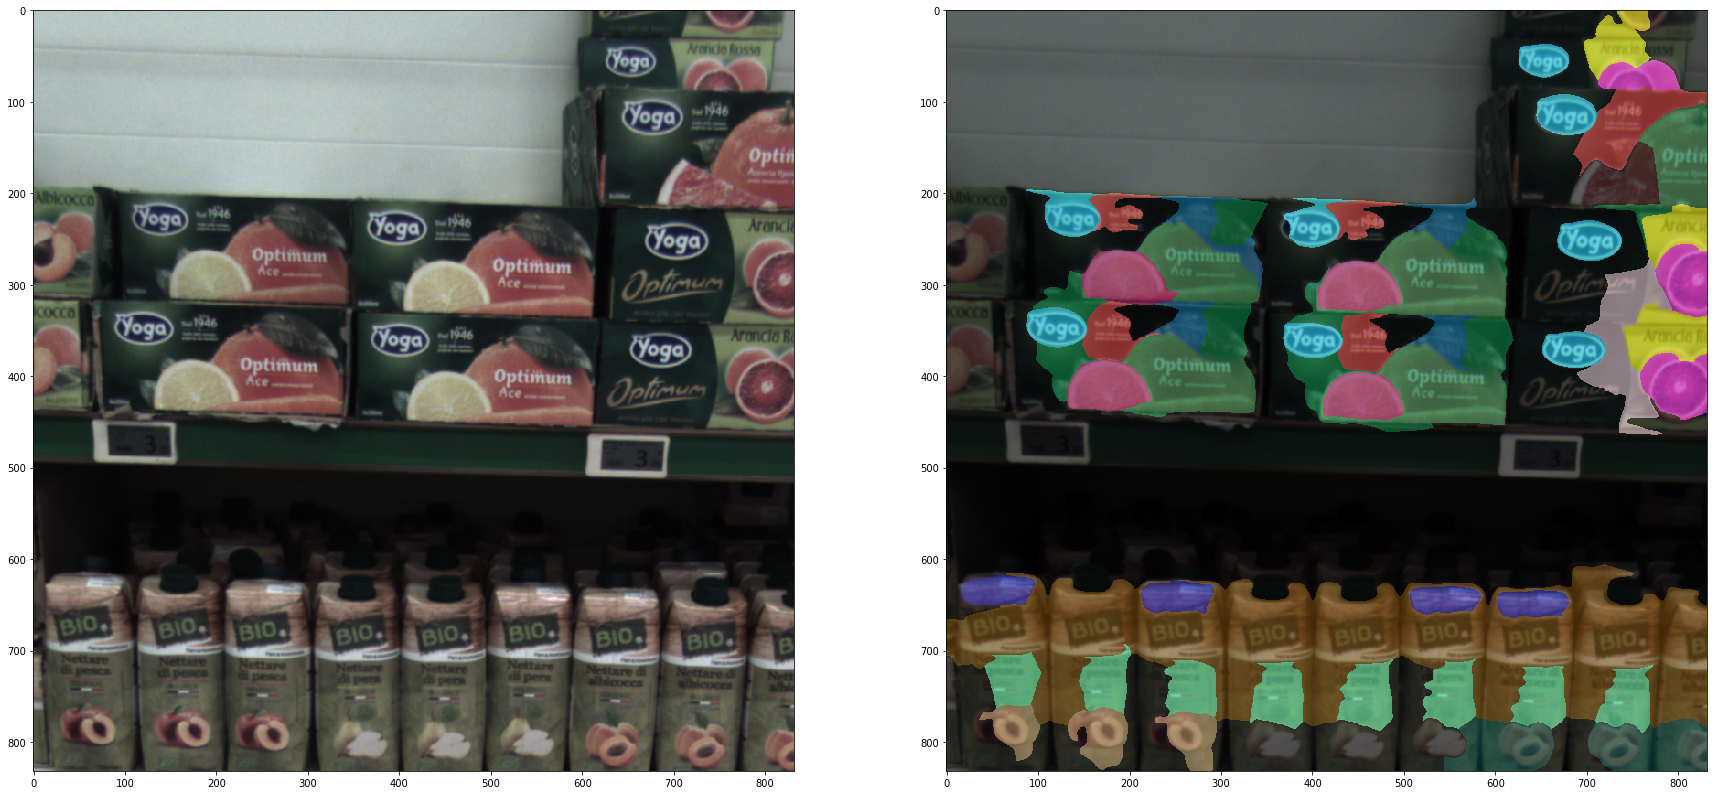

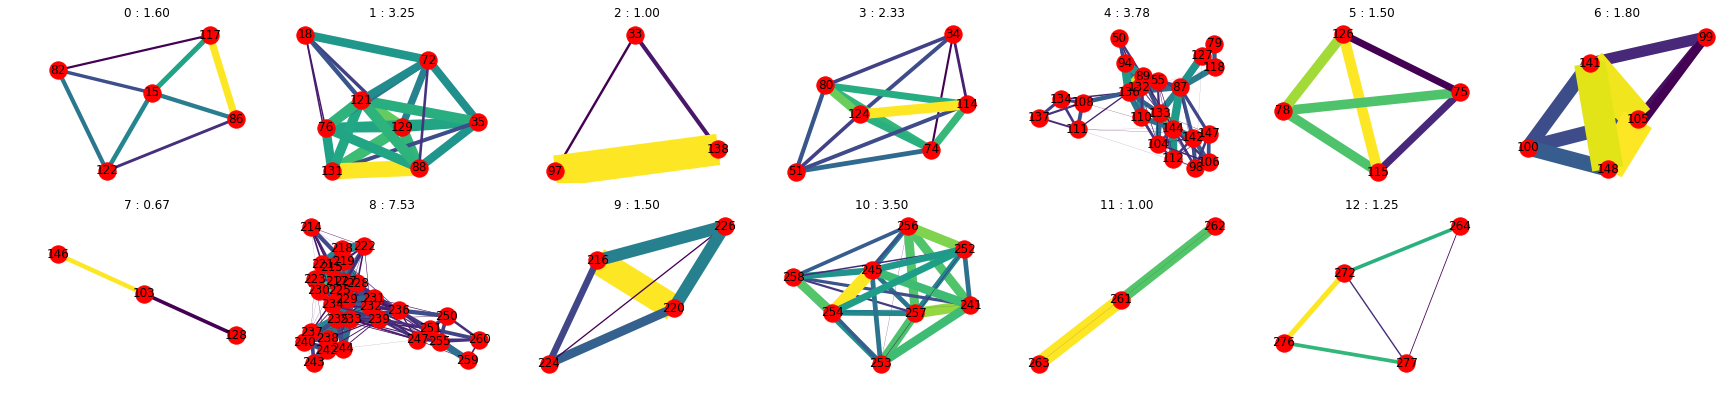

In [20]:
pred,rmask = utils.plot_spixel_segmentation(img, best_partition_nodes, segments)#, path=f"./res/superpixel/{N_SUPERPIXELS:05}.png")    
utils.draw_subgraphs(adj_mat, best_partition_nodes, maxw)

# Final result

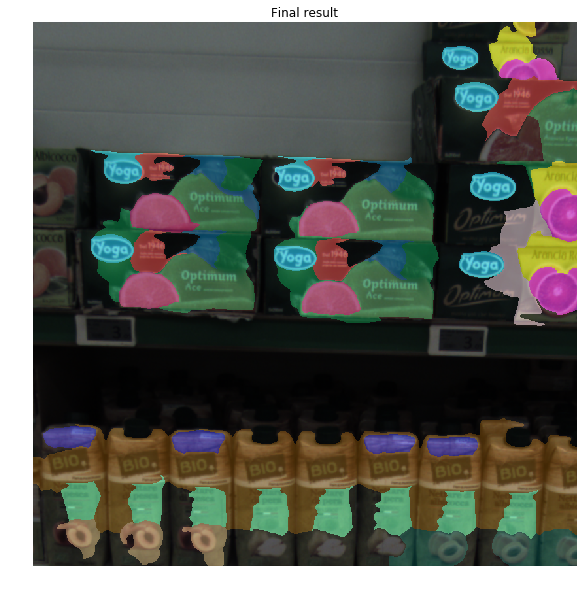

In [21]:
fig = plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title("Final result")
plt.imshow(rmask, alpha=0.5)
plt.axis('off')
plt.show()